In [1]:
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

import os, sys
util_path = os.path.abspath(os.path.join(os.path.pardir, 'utilities_and_data'))
if util_path not in sys.path and os.path.exists(util_path):
    sys.path.insert(0, util_path)

import plot_tools

plt.rc('font', size=12)

### Bayesian Data Analysis, 3rd ed
##  Chapter 6, demo 3

Posterior predictive checking  
Light speed example with a poorly chosen test statistic

In [32]:
data_path = os.path.abspath(
    os.path.join(
        os.path.pardir,
        'utilities_and_data',
        'light.txt'
    )
)
y = np.loadtxt(data_path)

n = len(y)
s2 = np.var(y, ddof=1)  # Here ddof=1 is used to get the sample estimate.
s = np.sqrt(s2)
my = np.mean(y)

In [33]:
# A second example of replications
nsamp = 1000
pps = np.random.standard_t(n-1, size=(n,nsamp))*np.sqrt(s2*(1+1/n)) + my
# Use the sample variance as a test statistic
# This is a poor choice since it corresponds directly to
# the variance parameter in the model which has been fitted
# to the data.
pp = np.var(pps, axis=0, ddof=1)

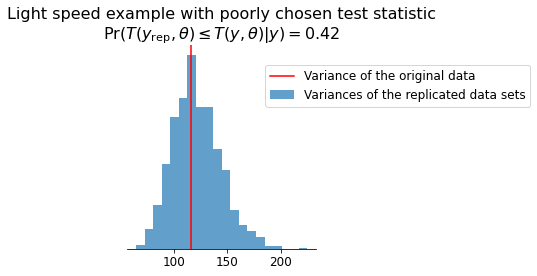

In [34]:
# plot
plt.hist(
    pp,
    20,
    label='Variances of the replicated data sets',
    color=plot_tools.lighten('C0', 0.3)
)
plt.axvline(s2, color='red', label='Variance of the original data')
plt.title(
    'Light speed example with poorly chosen test statistic\n'
    r'$\operatorname{Pr}(T(y_\mathrm{rep},\theta)\leq T(y,\theta)|y)=0.42$',
    fontsize=16
)
plt.legend(loc='center left', bbox_to_anchor=(0.7, 0.8))
plot_tools.modify_axes.only_x(plt.gca())
plt.tight_layout()

### Marginal posterior of $\mu$

In [167]:
num_replicates = 200

mu_post = np.random.standard_t(n-1, num_replicates)*np.sqrt(s2/n) + my
post_interval_95 = np.quantile(mu_post, q=[0.025, 0.975]) # agrees with BDA3 p. 67
print(np.round(post_interval_95, 1))

# order statistics
y_6 = sorted(y)[5]
y_61 = sorted(y)[60]

[23.  28.4]


In [168]:
Ty = np.abs(y_61 - mu_post) - np.abs(y_6 - mu_post)

Replicated datasets from posterior predictive:

In [169]:
replicates = np.random.standard_t(n-1, size=(num_replicates, n)) * np.sqrt(1+1/n)*s + my
replicates_sorted = np.sort(replicates)
replicates_6 = replicates_sorted[:, 5]
replicates_61 = replicates_sorted[:, 60]
Tyr = np.abs(replicates_61 - mu_post) - np.abs(replicates_6 - mu_post)

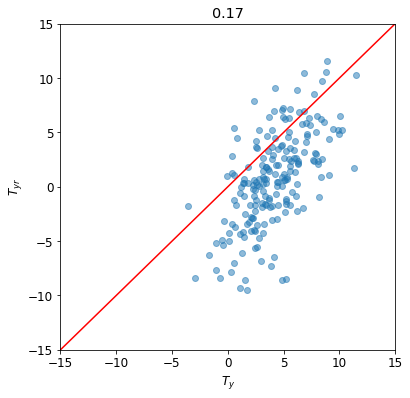

In [170]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(Ty, Tyr, alpha=0.5);
ax.set_xlim(-15, 15);
ax.set_ylim(-15, 15);
ax.plot([-15, 15], [-15, 15], color="red");
ax.set_xlabel("$T_y$");
ax.set_ylabel("$T_{yr}$");
plt.title(f"{np.mean(Tyr > Ty):.2f}");